# 01 - Exploratory Data Analysis - Initial EDA & Data Prep

(Python + tsforge)

**Goal** Get a fast, working understanding of our dataset *as a forecasting panel*, prove it’s modeling-ready, and produce a simple baseline forecast. We’ll keep it practical and direct:
- Load the prepared train/test splits (full + subset) from the setup.
- Run focused EDA for time series (frequency, completeness, zeros, outliers).
- Summarize/Pad/Visualize with `tsforge` wrappers (over Nixtla + pytimetk).


> We’re not polishing models here. We’re checking **data completeness**, **readiness**, and **signal health** 



In [1]:
import pandas as pd
import numpy as np

from tsforge.eda import *
from tsforge.feature_engineering import *
import tsforge as tsf   

c:\Users\tacke\Documents\GitHub\tsforge\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
c:\Users\tacke\Documents\GitHub\tsforge\.venv\Lib\site-packages\statsforecast\core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1. Business Understanding & Data Terminology  

The M5 dataset comes from Walmart’s daily sales records across the U.S., and it’s structured to reflect the way a real retailer manages its business. Each row of sales data links to a specific **item** (SKU) sold in a particular **store** within a given **state**. Items are grouped into **departments** and **categories**, which gives us a product hierarchy, while stores roll up to regions (states). Alongside sales, we also have **calendar data** (dates, events, SNAP/holiday flags) and **price data** (weekly store–item prices).  Understanding these dimensions—product, location, time, and price—is critical because they mirror the decisions a business actually makes: What to sell, where to sell it, when demand shifts, and at what price. This shared terminology will frame the rest of our exploration and modeling.

**What we’re trying to achieve**
- Translate dataset fields into *forecasting words* so the team speaks the same language.

**Key terms we’ll use consistently**
- **Series ID (`unique_id`)**: one item × one store (our basic unit to forecast).
- **Date (`date`)**: timestamp of the observation.
- **Target (`sales`)**: what we predict.
- **Hierarchy**: Location: `state_id → store_id` Product: `cat_id → dept_id → item_id).
- **Exogenous (X)**: `calendar` (events/holidays/SNAP), `prices` (weekly sell_price). 
- **Horizon**: 28 days (M5 standard).
- **Grain**: daily (we’ll also summarize to weekly/monthly for diagnostics).




## 2. First look at the data

### View Data

In [2]:
### View Data
train_df = pd.read_parquet('../data/input/processed/00_m5_sales_train.parquet')
train_df.head()

item_id    dept_id   cat_id store_id state_id       date  sales  \
0  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA 2013-07-18    1.0   
1  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA 2013-08-02    2.0   
2  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA 2013-08-04    1.0   
3  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA 2013-08-05    1.0   
4  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1       CA 2013-08-11    1.0   

            unique_id  
0  HOBBIES_1_001_CA_1  
1  HOBBIES_1_001_CA_1  
2  HOBBIES_1_001_CA_1  
3  HOBBIES_1_001_CA_1  
4  HOBBIES_1_001_CA_1

### Info

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2116761 entries, 0 to 2116760
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   item_id    object        
 1   dept_id    object        
 2   cat_id     object        
 3   store_id   object        
 4   state_id   object        
 5   date       datetime64[ns]
 6   sales      float32       
 7   unique_id  object        
dtypes: datetime64[ns](1), float32(1), object(6)
memory usage: 121.1+ MB


### Unique Values

In [4]:
train_df.nunique()

item_id      1612
dept_id         4
cat_id          2
store_id        3
state_id        2
date         1430
sales          97
unique_id    4836
dtype: int64

### Shape

In [5]:
train_df.shape

(2116761, 8)

### Check for duplicates

In [6]:
# Check for duplicates based on 'unique_id' and 'date'
duplicates = train_df.duplicated(subset=['unique_id', 'date'], keep=False)
duplicate_rows = train_df[duplicates]
print(duplicate_rows)

Empty DataFrame
Columns: [item_id, dept_id, cat_id, store_id, state_id, date, sales, unique_id]
Index: []


### Describe

In [7]:
train_df.describe()

date         sales
count                        2116761  2.116761e+06
mean   2014-07-26 20:05:28.393805312  2.438699e+00
min              2012-06-19 00:00:00  1.000000e+00
25%              2013-08-09 00:00:00  1.000000e+00
50%              2014-08-21 00:00:00  1.000000e+00
75%              2015-07-25 00:00:00  3.000000e+00
max              2016-05-22 00:00:00  6.010000e+02
std                              NaN  2.998685e+00

Dates:
The dataset spans from June 2012 to May 2016.
The median observation is around August 2014, so we’re sitting right in the middle of that 4-year window.
This tells us: plenty of history, and a broad enough window to catch multiple seasonal cycles.

Sales (our target):
The average sales per record is about 2.4 units.
But notice the 25th, 50th (median), and even 75th percentiles are very low — between 1 and 3 units.
That means the vast majority of series are very low volume.

On the other hand, the maximum is 601 units, way above the mean.
So demand is heavily skewed — lots of tiny sales, with some extreme spikes, or lots of low demand products with some high volume products.  This is very common.  And this will impact how we choose and analyze our metrics later on.

Standard deviation (std):
Missing here for the date (which is normal, pandas doesn’t compute std for timestamps).
For sales, std ~ 3.0, which is bigger than the mean (2.4).
A std larger than the mean is another red flag for volatility.”

### Histogram before filling 

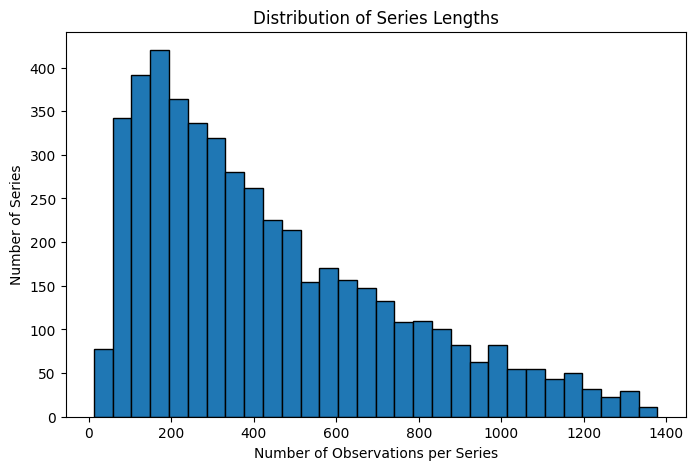

In [8]:
# Check series length distribution
import matplotlib.pyplot as plt

lengths = train_df.groupby("unique_id").size()

plt.figure(figsize=(8,5))
plt.hist(lengths, bins=30, edgecolor='black')
plt.title("Distribution of Series Lengths")
plt.xlabel("Number of Observations per Series")
plt.ylabel("Number of Series")
plt.show()

Alright, what we’re looking at here is a histogram of how many observations each product series has. In plain English: for each product, how many rows of data do we actually see?
Now, notice the shape.
Most products fall somewhere between about 100 and 300 observations. That’s the biggest hump in the middle.
We also see a long tail reaching out past 1,000 observations — so there are some products with really long histories.
And on the left-hand side, there are products with fewer than 100 points — those are the new or late-starting items.

Right now, we haven’t padded the data yet. That means this histogram is counting observed rows only, not the full calendar. If a product missed a bunch of days — say it only recorded sales every few days — it might look like it has a shorter history here than it really does.

This gives us a rough sense of history length across products. Most items have some decent history, some have very long histories, and quite a few have short ones.
But to know the true coverage in calendar time, we’ll need to fill the gaps first. After we pad missing dates, we’ll come back and check this again to see the real picture.


## 3. Time Series Summary Diagnostics  

Once we’ve done some basic checks on the data we are working with, it’s helpful to generate a quick diagnostic report. The `summary_diagnostics` function from `tsf` provides an at-a-glance view of each series: start and end dates, length of history, % of missing values, zero counts, and basic statistics. This makes it easy to spot data quality issues early (like short series, sparse demand, or excessive zeros) before moving further into modeling.

### Summary Diagnostics

In [9]:
diagnostics_df = summary_diagnostics(train_df, id_col="unique_id", date_col="date", value_col="sales")

diagnostics_df.head()

unique_id start_date   end_date  n_obs freq  n_expected  \
0  HOBBIES_1_001_CA_1 2013-07-18 2016-05-22    436   1D        1040   
1  HOBBIES_1_001_CA_2 2013-07-27 2016-05-22    377   1D        1031   
2  HOBBIES_1_001_TX_1 2013-07-16 2016-05-22    222   2D         521   
3  HOBBIES_1_002_CA_1 2012-06-21 2016-05-17    331   1D        1427   
4  HOBBIES_1_002_CA_2 2012-06-21 2016-05-22    201   1D        1432   

   is_regular  pct_missing  mean_value  sd_value  cv_value  skewness  \
0       False    58.076923    1.451835  0.773094  0.532495  1.954353   
1       False    63.433560    1.493369  0.779104  0.521709  1.897243   
2       False    57.389635    1.229730  0.543509  0.441974  2.974822   
3       False    76.804485    1.250755  0.618374  0.494400  3.014323   
4       False    85.963687    1.129353  0.364944  0.323144  2.807985   

   pct_zeros  pct_outliers  trend_strength  
0        0.0      2.981651        0.036560  
1        0.0      3.448276        0.001157  
2        0.0      3.603604        0.011560  
3        0.0      1.208459        0.001071  
4        0.0      0.995025        0.000187

when you run this summary_diagnostics function, you most likely will not go through this series by series. You will use it to filter or sort certain elements and take note of watchouts. Lets go through each of these features and discuse how to use them to guide you on your EDA

### Summary Diagnostics by Date

In [10]:
diagnostics_df.sort_values(by = 'start_date', ascending = False).head(5)

unique_id start_date   end_date  n_obs freq  n_expected  \
2881  HOUSEHOLD_1_405_CA_2 2016-02-16 2016-05-22     78   1D          97   
2608  HOUSEHOLD_1_311_CA_2 2016-02-14 2016-05-22     80   1D          99   
2509  HOUSEHOLD_1_278_CA_2 2016-02-05 2016-05-22     75   1D         108   
1754  HOUSEHOLD_1_020_TX_1 2015-10-14 2016-05-22     54   1D         222   
2936  HOUSEHOLD_1_423_TX_1 2015-09-26 2016-05-18     30   1D         236   

      is_regular  pct_missing  mean_value  sd_value  cv_value  skewness  \
2881       False    19.587629    2.294872  1.228545  0.535344  0.607581   
2608       False    19.191919    2.262500  1.393872  0.616076  1.160305   
2509       False    30.555556    1.626667  0.926682  0.569681  1.727964   
1754       False    75.675676    1.481481  0.720082  0.486056  1.442352   
2936       False    87.288136    1.233333  0.568321  0.460801  2.304679   

      pct_zeros  pct_outliers  trend_strength  
2881        0.0      0.000000    4.994964e-03  
2608        0.0      0.000000    3.445031e-04  
2509        0.0      2.666667    6.128708e-04  
1754        0.0      1.851852    7.197541e-08  
2936        0.0      6.666667    4.133885e-02

### Summary Diagnostics by Obs

In [11]:
diagnostics_df.sort_values(by = 'n_obs').head(5)


unique_id start_date   end_date  n_obs freq  n_expected  \
1415    HOBBIES_2_056_TX_1 2015-03-28 2016-02-29     12   2D         170   
2805  HOUSEHOLD_1_378_CA_1 2014-05-10 2016-05-15     22   4D         185   
632     HOBBIES_1_217_TX_1 2013-01-11 2016-05-10     23  11D         111   
75      HOBBIES_1_026_CA_1 2014-01-23 2016-05-22     24   1D         851   
1322    HOBBIES_2_025_TX_1 2014-06-01 2015-11-24     25  12D          46   

      is_regular  pct_missing  mean_value  sd_value  cv_value  skewness  \
1415       False    92.941176    1.000000  0.000000  0.000000       NaN   
2805       False    88.108108    1.045455  0.213201  0.203931  4.364358   
632        False    79.279279    1.043478  0.208514  0.199826  4.477214   
75         False    97.179788    1.083333  0.408248  0.376845  4.587316   
1322       False    45.652174    1.120000  0.439697  0.392586  3.645072   

      pct_zeros  pct_outliers  trend_strength  
1415        0.0           NaN             NaN  
2805        0.0      4.545455        0.085478  
632         0.0      4.347826        0.004132  
75          0.0      4.166667        0.120000  
1322        0.0      4.000000        0.095491

In [12]:
train_df[train_df.unique_id == 'HOBBIES_2_056_TX_1'].sort_values(by='date').head(5)

item_id    dept_id   cat_id store_id state_id       date  sales  \
558964  HOBBIES_2_056  HOBBIES_2  HOBBIES     TX_1       TX 2015-03-28    1.0   
558965  HOBBIES_2_056  HOBBIES_2  HOBBIES     TX_1       TX 2015-05-05    1.0   
558966  HOBBIES_2_056  HOBBIES_2  HOBBIES     TX_1       TX 2015-05-06    1.0   
558967  HOBBIES_2_056  HOBBIES_2  HOBBIES     TX_1       TX 2015-05-08    1.0   
558968  HOBBIES_2_056  HOBBIES_2  HOBBIES     TX_1       TX 2015-06-18    1.0   

                 unique_id  
558964  HOBBIES_2_056_TX_1  
558965  HOBBIES_2_056_TX_1  
558966  HOBBIES_2_056_TX_1  
558967  HOBBIES_2_056_TX_1  
558968  HOBBIES_2_056_TX_1

### Summary Diagnostics by Trend

In [13]:
diagnostics_df.sort_values(by = 'trend_strength').head(5)

unique_id start_date   end_date  n_obs freq  n_expected  \
3623  HOUSEHOLD_2_111_TX_1 2012-08-13 2015-10-16     43   1D        1160   
1501    HOBBIES_2_085_CA_2 2012-06-23 2016-05-21    305   1D        1429   
2873  HOUSEHOLD_1_402_TX_1 2014-05-19 2016-05-18     57   2D         366   
1148    HOBBIES_1_391_TX_1 2012-06-22 2016-04-27     81   1D        1406   
3314  HOUSEHOLD_2_008_TX_1 2012-07-18 2016-05-10    207   1D        1393   

      is_regular  pct_missing  mean_value  sd_value  cv_value  skewness  \
3623       False    96.293103    1.186046  0.663892  0.559752  4.725104   
1501       False    78.656403    1.662295  1.280183  0.770130  2.646981   
2873       False    84.426230    1.122807  0.331133  0.294915  2.298447   
1148       False    94.238976    1.148148  0.357460  0.311336  1.980887   
3314       False    85.139986    1.231884  0.525420  0.426517  2.611959   

      pct_zeros  pct_outliers  trend_strength  
3623        0.0      2.325581   -1.413739e-07  
1501        0.0      2.950820   -1.090516e-07  
2873        0.0      0.000000   -8.719309e-08  
1148        0.0      0.000000   -8.292821e-08  
3314        0.0      2.898551   -6.370273e-08

**Coverage & Dates**

start_date, end_date
* Start date and end date simply tell us the calendar coverage for each series. Things to check here are what date ranges are we dealing with.  Do we see a lot of recent launches with limited history? have items disappeared?  Do all series cover the same period.

Its very common for some products to have been around since the very beginning of the dataset, while others may have only just launched a few months ago.

That difference matters. A product with four years of history gives us plenty of data to detect seasonality, trend, and patterns. But a product that only started three months ago? That’s a very short history — and it makes forecasting much tougher. You can’t expect the same modeling power from both.

Short histories also make cross-validation tricky. With only a handful of points, you don’t have enough room to create multiple training and test windows. That means you either have to skip CV on those items, or handle them differently.”

n_obs
* This is the number of actual observations. More history means more chance to detect seasonality and trends. Very short series might only allow simple models like Naïve.”
Use it: Filter out series with <2× forecast horizon observations.

**Frequency & Regularity**

freq
This is the grain the function detects: daily, weekly, monthly. If you expected daily and it says weekly, you’ve got a data problem.”
Use it: Sanity check your assumptions.

n_expected
* If the series is supposed to be daily, and the coverage is 365 days, then n_expected = 365. If we only see 300 actual points, we’re missing 65.”

is_regular
* Regular means every period is there. If this is false, you either have missing dates or irregular reporting.”
Use it: True → proceed. False → fix with fill_gaps().

pct_missing
* Shows how much of the expected history is missing. 1–2% missing might be fine, 20% missing is a red flag.”
Use it: If high → treat before modeling (interpolation, forward-fill, or roll up).

**Value Stats**

mean_value / sd_value / cv_value
Talking point:

This shows the scale and volatility. CV = Coefficient of variation = standard deviation ÷ mean. Low CV means (close to 0) stable demand - easier to model, high CV means noisy demand.”
Use it: Segment products: low CV → stable forecasts; high CV → harder, maybe need smoothing or ML.  There are some callouts to CV, and even though it is commonly used in business as a measure of forecastability, there are caveats to it. For example a linear trend item can have a high CV but also be highly forecastable.  It doesnt invalidate the benefits of CV, it just means you need to be aware of its limitations.  The 3 biggest callouts are typically
* Trend, Seasonality both inflates CV
* Short series or series with a low mean value can also blow up CV
 

skewness
Talking point:

Skewness measures whether a series is lopsided or not.  Do most values sit on one side with occasional big swings on the other.
Large positive skew:
Most of the time demand is modest, but every so often there’s a huge upward spike.
Think promotions, holidays, or special events where demand shoots up way above the norm.

Large negative skew:
Most of the time demand is steady or high, but occasionally you get sharp downward drops.
Think inventory deloads, stockouts, system shut-offs where demand suddenly crashes.

Skewness is like a red flag for unusual behavior.  If its way off 0, you probably have certain events hidden in the demand pattern.  It wont tell you where, but it gives you some guidance and which series to maybe look at.


**Intermittency & Outliers**

pct_zeros
* How much of the series is zero demand. If this is high, we call it intermittent demand. Those series need special models (Croston/TSB) or middle-out forecasting, or - ML models”
First thing you will notice is % zeries is all 0.  This is very common in real world data.  Remember we said we had missing periods?  Well, typically when you gets sales data, or shipping data, you only collect the events and sum them up.  Thus when there was no demand, no sales, no shipments, there just simply isnt a data point.  So our data right now, has no 0 values, because 0 values just show up as missing dates.  Once we fill in our missing periods, we will see these numbers go up. 
In terms of intermittency, There is no simple rule of thumb for what classifies a series as intermittent or non-intermittent.  Some rought guidance, if 20-30% are 0, its likely intermittent, and >50% is definitely intermittent.


pct_outliers
* Percent outliers is our quick way of spotting points that might be out of the ordinary. Here we’re using a simple rule: any point more than 3 standard deviations above or below the mean gets flagged.
Now, this isn’t the only way to detect outliers — we’ll dive into more advanced methods later. But for now, think of this as a spotlight: it doesn’t prove something is wrong, it just tells you ‘hey, look here.’
And when you do look, you might find the spike is real — maybe a promo or a stockout — or you might discover it’s bad data. The key is not to delete blindly, but to investigate.


**Trend**

trend_strength
* With trend strength, all we’re really asking is: if I drew a straight line through this series, how much of the ups and downs could that line explain?
If the number is close to 1, that line is doing a great job — the series is strongly trending up or down.
If it’s close to 0, the line doesn’t help at all — the series is basically flat or just bouncing around.

Sometimes the value even goes negative. And no, that doesn’t mean it’s a ‘negative trend.’ It means the line actually made things worse — it explained the series less than if we had just guessed the average every period. Think of it as your data saying, ‘don’t bother fitting me with a line, it won’t help.’

So here’s how to use this:

High trend strength → pick models that are good at trends, like ETS with a trend component, ARIMA, or possibly a univariate + ML model ensemble.
If you have Low or negative trend strength → don’t force a trend, it might make your model worse.

## 4. Padding Missing Dates with `fill_gaps_plus`

From our diagnostics, we saw that some series have gaps — days where no row exists in the data.
Before we can model, we need to make sure every series has a complete calendar: one row per date per ID. Without that, models will misinterpret missing days as “nothing happened,” and we won’t be able to align or roll things up later.

Nixtla provides a fast utility called fill_gaps
 that expands each time series into a full sequence of dates at the chosen frequency.

tsforge builds on this by adding some extra features that are often needed in practice:
* It can automatically carry along static columns (like category, department, or store info) so you don’t have to worry about merging them back later.
* It gives you flexibility for dynamic exogenous data (like price, promo, SNAP). We’ll talk more about how to handle those in a later module.
* It lets you define a fill strategy for your target. This matters because the “right” way to fill depends on why the gaps exist.

Lastly, it also allows for you to define a fill strategy for your target.  Dependong on why the gaps are present in your dataset, you might want to choose different fill strategies.  In our case, missing periods are due to no sales, so filling with 0 makes sense for us right now.  If gaps are from data collection issues or system downtime, then 0 could be misleading — maybe leaving them as NaN or interpolating is better

That’s the key point here: filling gaps isn’t just a technical step, it’s a business decision. You always want to choose the strategy that matches the story behind your data.


### Fill gaps plus

In [14]:
filled = tsf.fill_gaps_plus(
    train_df,
    id_col="unique_id",
    time_col="date",
    target_col="sales",
    freq="D",
    static_cols=["item_id", "dept_id", "cat_id", "store_id", "state_id"],
    dynamic_fill={
    #    "snap": "zero",         # missing SNAP flags = 0
    #    "price": "ffill",       # carry last price forward
    #    "temp": "interpolate"   # smooth missing weather
    },
    target_fill="zero",
    verbose=True
)

[fill_gaps_plus] Input shape: (2116761, 8)
[fill_gaps_plus] Output shape: (6141593, 8)
[fill_gaps_plus] Added 4024832 rows to fill gaps.


In [15]:
filled.head()

unique_id       date  sales        item_id    dept_id   cat_id  \
0  HOBBIES_1_001_CA_1 2013-07-18    1.0  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1  HOBBIES_1_001_CA_1 2013-07-19    0.0  HOBBIES_1_001  HOBBIES_1  HOBBIES   
2  HOBBIES_1_001_CA_1 2013-07-20    0.0  HOBBIES_1_001  HOBBIES_1  HOBBIES   
3  HOBBIES_1_001_CA_1 2013-07-21    0.0  HOBBIES_1_001  HOBBIES_1  HOBBIES   
4  HOBBIES_1_001_CA_1 2013-07-22    0.0  HOBBIES_1_001  HOBBIES_1  HOBBIES   

  store_id state_id  
0     CA_1       CA  
1     CA_1       CA  
2     CA_1       CA  
3     CA_1       CA  
4     CA_1       CA

### Summary Diagnostics Filled

In [16]:
summary_diagnostics(filled, id_col="unique_id", date_col="date", value_col="sales")

unique_id start_date   end_date  n_obs freq  n_expected  \
0       HOBBIES_1_001_CA_1 2013-07-18 2016-05-22   1040    D        1040   
1       HOBBIES_1_001_CA_2 2013-07-27 2016-05-22   1031    D        1031   
2       HOBBIES_1_001_TX_1 2013-07-16 2016-05-22   1042    D        1042   
3       HOBBIES_1_002_CA_1 2012-06-21 2016-05-22   1432    D        1432   
4       HOBBIES_1_002_CA_2 2012-06-21 2016-05-22   1432    D        1432   
...                    ...        ...        ...    ...  ...         ...   
4831  HOUSEHOLD_2_515_CA_2 2014-01-18 2016-05-22    856    D         856   
4832  HOUSEHOLD_2_515_TX_1 2013-12-30 2016-05-22    875    D         875   
4833  HOUSEHOLD_2_516_CA_1 2012-06-22 2016-05-22   1431    D        1431   
4834  HOUSEHOLD_2_516_CA_2 2012-06-19 2016-05-22   1434    D        1434   
4835  HOUSEHOLD_2_516_TX_1 2012-06-23 2016-05-22   1430    D        1430   

      is_regular  pct_missing  mean_value  sd_value  cv_value  skewness  \
0           True          0.0    0.608654  0.874030  1.436005  1.694818   
1           True          0.0    0.546072  0.859872  1.574650  1.832641   
2           True          0.0    0.261996  0.562582  2.147291  2.597845   
3           True          0.0    0.289106  0.605305  2.093712  2.731710   
4           True          0.0    0.158520  0.415473  2.620957  2.766526   
...          ...          ...         ...       ...       ...       ...   
4831        True          0.0    0.223131  0.528024  2.366432  2.606717   
4832        True          0.0    0.125714  0.403321  3.208232  3.885025   
4833        True          0.0    0.172607  0.433207  2.509797  2.776481   
4834        True          0.0    0.209205  0.507610  2.426377  2.920148   
4835        True          0.0    0.130769  0.374620  2.864742  3.077486   

      pct_zeros  pct_outliers  trend_strength  
0     58.076923      1.250000        0.027114  
1     63.433560      1.260912        0.002542  
2     78.694818      3.934741        0.000147  
3     76.885475      1.256983        0.001436  
4     85.963687      1.675978        0.006118  
...         ...           ...             ...  
4831  82.242991      3.855140        0.006741  
4832  89.600000      1.828571        0.010815  
4833  84.626136      1.537386        0.011269  
4834  82.845188      3.138075        0.002036  
4835  88.111888      1.048951        0.000010  

[4836 rows x 15 columns]

now we see all our freq are D, all our series are regular, no values are missing, and we also see our pct_zeroes now are no longer 0. 

### Histogram Filled

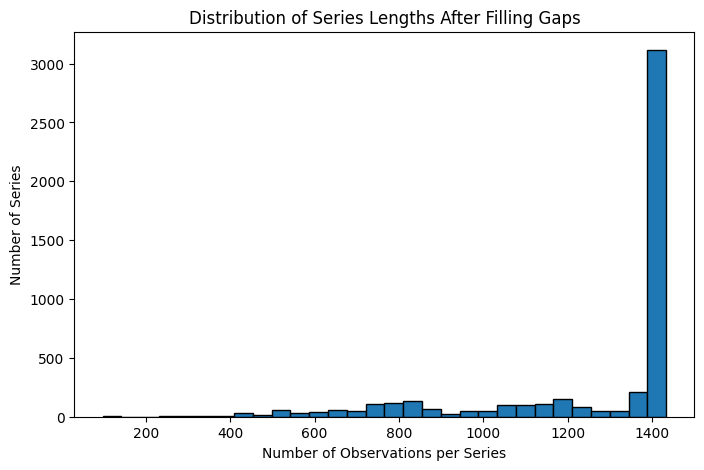

In [17]:
lengths_filled = filled.groupby("unique_id").size()

plt.figure(figsize=(8,5))
plt.hist(lengths_filled, bins=30, edgecolor='black')
plt.title("Distribution of Series Lengths After Filling Gaps")
plt.xlabel("Number of Observations per Series")
plt.ylabel("Number of Series")
plt.show()

Here’s the new histogram after we filled the gaps.

What changed? Now each series has been expanded to cover its full history — from its own first recorded date to its own last recorded date — with every missing day in between padded in. That’s why you see this huge spike on the right. Many products were sold for the entire length of the dataset, so once we fill their gaps, they all end up with the same number of observations, about 1,400 days.

But notice: not every series lands in that spike. Some are shorter — those are the products that launched later or were discontinued earlier. For those, we only expand between their own start and end dates. We’re not forcing every product back to the global dataset start date, because that would create a bunch of fake ‘pre-launch’ zeros.

So what does this tell us?

After padding, most products have consistent, complete calendars, which is critical for modeling.

A big group of products has full-length history, while some series are clearly newer or ended early.

This alignment makes our data cleaner and ready for forecasting, but it also highlights that new products with shorter histories will still be harder to model and evaluate.

### Export processed/filled Data

In [18]:
# Save file for the next section
filled.to_parquet("../data/input/processed/01_train_df.parquet", index=False)

## 5. Visualizing the Time Series  

Okay, now that we’ve checked the dataset, run our diagnostics, and filled in the gaps, we’re ready for the fun part — visualizing the time series.
Why do we care about plots? Because a picture makes patterns jump out in ways that numbers alone can’t.
Diagnostics told us which series had gaps, zeros, or skew.
But plots let us see trend, seasonality, volatility, and anomalies directly.
This step isn’t just for EDA — it’s also about building intuition. You’ll start to recognize which series are easy to forecast, which ones will be challenging, and which ones need special handling.
In the next few cells, we’ll walk through several plotting functions I’ve built:
First the simple line plots,
Then zooming in on different windows,
Seasonal plots,
And finally some diagnostics like ACF/PACF.
The goal is not just to make pretty pictures — it’s to train your eyes to spot the same things our models will later try to learn.”


### Plot Time Series

In [19]:
# Overlay a few series
tsf.plot_timeseries(
    filled,
    id_col='unique_id',
    date_col='date',
    value_col='sales',
    max_ids=6,
    engine='plotly',
    mode='facet',
    wrap = 3,
    smooth_window=28 
)



In [20]:
# Use a dropdown few series
fig = tsf.plot_timeseries(
    filled,
    id_col='unique_id',
    date_col='date',
    value_col='sales',
    max_ids=6,
    engine='plotly',
    mode='dropdown',
    smooth_window=28 
)
fig.show()


### Plot Time Series Temporal Agg

In [21]:
# Use a dropdown few series
fig = tsf.plot_timeseries(
    filled,
    id_col='unique_id',
    date_col='date',
    value_col='sales',
    max_ids=6,
    engine='plotly',
    mode='dropdown',
    smooth_window=4,
    freq = 'W'
)
fig.show()


In [22]:
# Use a dropdown few series
fig = tsf.plot_timeseries(
    filled,
    id_col='unique_id',
    date_col='date',
    value_col='sales',
    max_ids=6,
    engine='plotly',
    mode='dropdown',
    smooth_window=4,
    freq = 'ME'
)
fig.show()


### Plot Time Series Group Agg

In [23]:
tsf.plot_timeseries(
    df=train_df,   
    id_col ="unique_id",
    date_col="date",
    value_col="sales",
    group_col="dept_id",
    ids=3,
    mode = 'dropdown',
    smooth_window=28
)

In [24]:
tsf.plot_timeseries(
    df=train_df,   
    id_col ="unique_id",
    date_col="date",
    value_col="sales",
    group_col="dept_id",
    ids=3,
    mode = 'dropdown',
    smooth_window=4,
    freq = 'ME'
)

### Plot Time Series Target Transformation

In [25]:
tsf.plot_timeseries(
    filled,
    id_col='unique_id',
    date_col='date',
    value_col=lambda d: np.log1p(d["sales"]),
    ids=5,
    smooth_window=28,
    mode = 'dropdown'
)


### Plot Seasonal

In [26]:
tsf.plot_seasonal(
    df=filled,
    id_col="unique_id",
    date_col="date",
    value_col="sales",
    #group_col="dept_id",
    ids=3,   # one specific series
    freq="M",                   # monthly cycle
    engine='plotly',
    mode="dropdown"  ,           # overlay | facet | dropdown
    kind = 'line'

)


### Plot Heatmap by ID

In [27]:
tsf.plot_calendar_heatmap(
    df=filled,
    id_col="unique_id",
    date_col="date",
    value_col="sales",
    ids=3,
    mode="dropdown",

)

### Plot Heatmap by Group

In [28]:
tsf.plot_calendar_heatmap(
    df=filled,
    id_col="unique_id",
    date_col="date",
    value_col="sales",
    group_col="dept_id",   #aggregate by department
    ids=5,
    mode="dropdown",
)

In [29]:
tsf.plot_calendar_heatmap(
    df=filled,
    id_col="unique_id",
    date_col="date",
    value_col="sales",
    group_col="dept_id",   #aggregate by department
    wrap = 3,
    ids=5,
    mode="facet",
)

### Plot Distributions

Before modeling, it’s important to see how demand is distributed.  
- Most SKUs sell **0–5 units on a typical day**.  
- A few days have large spikes (promotions or holidays).  
- This skewed, zero-inflated distribution is common in retail.  
- Visualizing both raw and log-transformed distributions highlights these patterns.

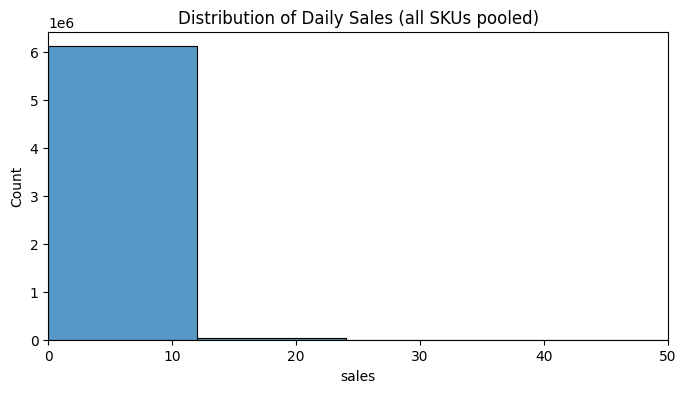

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.histplot(filled['sales'], bins=50, kde=False)
plt.xlim(0, 50)   # cap to focus on the body (filter out extreme spikes)
plt.title("Distribution of Daily Sales (all SKUs pooled)")
plt.show()

This chart shows the distribution of daily sales values across all products. Notice how most of the mass is piled up very close to zero, and then we have a long right tail of spikes. That tells us two things:
* Most products have very low daily sales (intermittency).
* We occasionally get very large spikes (promotions or anomalies).

That’s why demand forecasting is tricky — models need to handle both the low-level noise and those rare bursts.

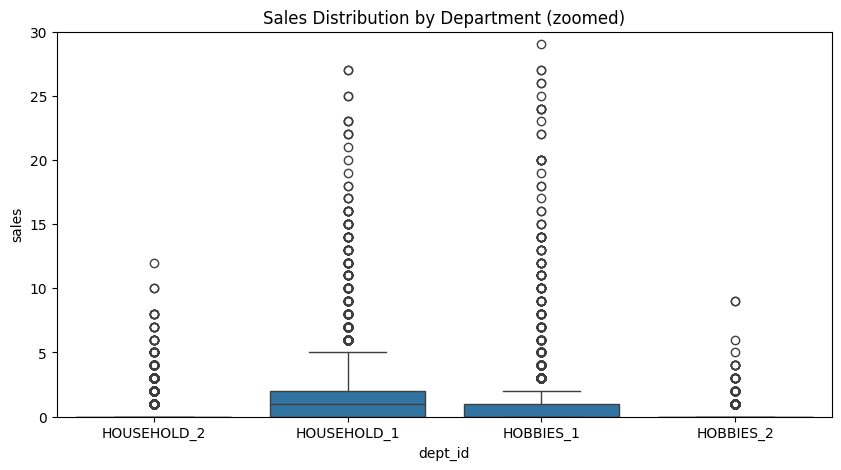

In [31]:
sample_df = filled.sample(20000, random_state=42)  # downsample for speed

plt.figure(figsize=(10,5))
sns.boxplot(x='dept_id', y='sales', data=sample_df)
plt.ylim(0, 30)  # zoom in
plt.title("Sales Distribution by Department (zoomed)")
plt.show()


This plot shows distribution of sales by department side by side.  Median, interquartile range, and outlier.   This is useful for spotting which departments are steady vs which have lots of outliers.
Notice how Household 2 and HObbies 2 have mostly 0 values, the IQR range isnt even visible in this range because its squashed to 0. While Hobbies 1 also has lots of 0s with a median at 0, but also has lots of outliers. That helps us understand which groups are more intermittent and which are more stable.

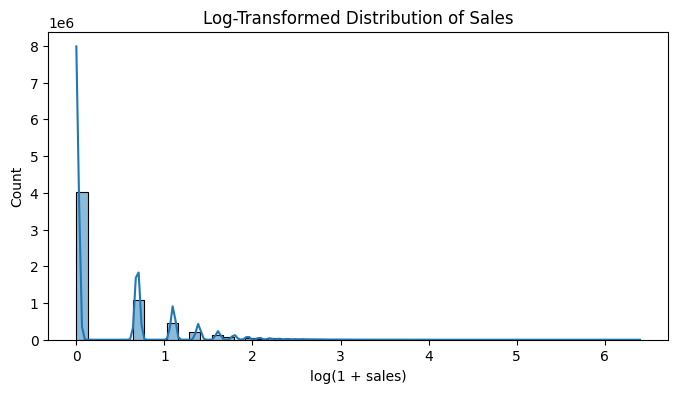

In [ ]:
import numpy as np

plt.figure(figsize=(8,4))
sns.histplot(np.log1p(filled['sales']), bins=50, kde=True)
plt.title("Log-Transformed Distribution of Sales")
plt.xlabel("log(1 + sales)")
plt.show()

We can also take a log1p transform of the sales.  Log1p basically adds 1 to the sales, and then does a log.  The reason we add 1 is because the log of 0 is undefined.  So we add 1 to all series so its >0, then take the log.  In doing this, it helps 'spread out' the values a bit to see the distribution.  Log transforms squash those extreme spikes down to a more manageable scale. Models can then learn relative changes better, instead of being dominated by a handful of massive promo days.

### Plot Pareto

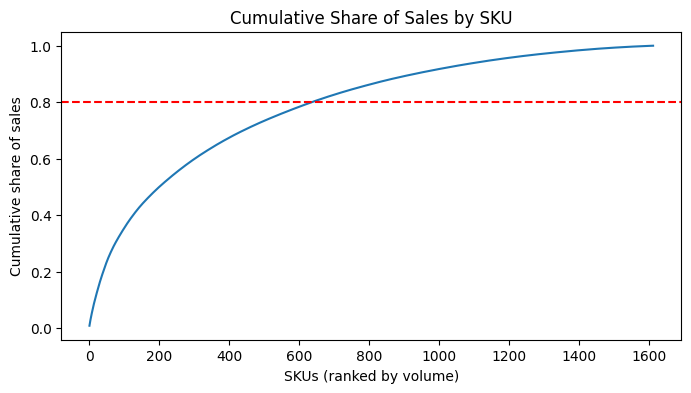

In [33]:
sku_volume = (
    filled.groupby("item_id")["sales"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
sku_volume["cum_share"] = sku_volume["sales"].cumsum() / sku_volume["sales"].sum()

plt.figure(figsize=(8,4))
sns.lineplot(x=range(1, len(sku_volume)+1), y=sku_volume["cum_share"])
plt.axhline(0.8, color="red", ls="--")
plt.title("Cumulative Share of Sales by SKU")
plt.xlabel("SKUs (ranked by volume)")
plt.ylabel("Cumulative share of sales")
plt.show()

This chart is showing the Pareto principle in action. When we rank SKUs by their total sales, we see that most of the company’s volume is concentrated in a relatively small slice of products.
Now, in the classic 80/20 rule, about 20% of items drive 80% of sales. In our case it’s a little different: it actually takes about 600 SKUs — roughly 37% of the assortment — to get to 80% of the volume.
Why does this matter?
* Those high-volume SKUs are where even small improvements in forecast accuracy deliver big business impact.
* The long tail of low-volume SKUs is individually less important and often much harder to forecast. For those, it’s common to use simpler models, or to roll them up to a higher level.

So, this analysis helps us prioritize: focus energy on the heavy hitters, while treating the long tail with approaches that are pragmatic and scalable.

### Plot Autocorrelation

ACF and PACF plots are classic time series tools. They show how today’s sales are correlated with past days.
At the SKU level, things are often noisy and intermittent. You might see some correlation at lag=1 (yesterday) or lag=7 (last week), but it’s messy.
At the department level, patterns stand out more clearly. Weekly seasonality, monthly cycles — these become visible because we’ve smoothed across many SKUs.
In practice, we don’t often rely on ACF/PACF at scale anymore — modern models detect these patterns automatically. But it’s still valuable to know what these plots show, and how aggregation can change the picture.”

In [34]:
tsf.plot_autocorrelation(
    df = filled,
    id_col= 'unique_id',
    date_col= 'date',
    value_col='sales',
    ids= 3,
    lags = "[1:60]",
    freq ='D',
    mode ='dropdown',
    alpha = 0.05,
)


See the blue shaded region around zero? That’s the confidence band. The alpha value controls how wide it is.
With alpha=0.05, we’re asking for a 95% confidence interval. That means if the series were just white noise, about 95% of the autocorrelations should land inside the band.
If a bar pokes outside the band, it’s unlikely to be just random noise — it’s probably a real correlation.
So, alpha is basically how strict we want to be. Smaller alpha → wider bands → fewer correlations flagged as significant.

You can see that almost all lags fall inside the threshold of just noise.  That doesnt mean they are not useful, in the real world its hard to find that text book level correlation and confidence.  
So what’s the “real-world threshold”?

We don’t use a fixed alpha at all. The 95% bands are more of a visual cue.
In practice, analysts look for:
Consistent spikes at meaningful lags (e.g. lag=7 for weekly, lag=12 for monthly).
Shape of the decay (slow taper vs sharp cut) to diagnose AR vs MA structure.
It’s more about pattern recognition than statistical hypothesis testing.

In [35]:
tsf.plot_autocorrelation(
    df = train_df,
    id_col= 'unique_id',
    date_col= 'date',
    value_col='sales',
    ids= 3,
    lags = "[1:60]",
    group_col='dept_id',
    freq ='D',
    mode ='dropdown',
    alpha = 0.2,
)

## 6. Red Flag Checks

Okay, so at this point our data is almost model-ready: it’s clean, consistent, and in the right shape. But being model-ready doesn’t necessarily mean it’s forecast-ready.

This is where red flag checks come in. These are like a medical check-up for each series. We’re not asking ‘will the code run?’ — we’re asking, ‘are there characteristics in this series that could trip up a model or lead to misleading forecasts?’

Typical red flags include things like:

* Outliers – one-off spikes or crashes that distort the signal.
* Intermittency – lots of zeros, which most models don’t handle well.
* Structural breaks – sudden shifts in level (like COVID or a relaunch).
* Too short or constant series – not enough information for a model to learn from.

Catching these upfront helps us make smarter choices later: should we cleanse? should we use a specialized model? should we roll up to a higher level?

In [36]:
check_red_flags(
    df=filled,
    id_col="unique_id",
    date_col="date",
    target_col="sales",
    horizon=30
)

🚩 Running Red Flag Checks...

Series: HOBBIES_1_001_CA_1
  outliers             ✅ OK
  intermittent         🚩 FLAGGED
  structural_break     ✅ OK
  short_history        ✅ OK
  constant             ✅ OK

Series: HOBBIES_1_001_CA_2
  outliers             ✅ OK
  intermittent         🚩 FLAGGED
  structural_break     ✅ OK
  short_history        ✅ OK
  constant             ✅ OK

Series: HOBBIES_1_001_TX_1
  outliers             🚩 FLAGGED
  intermittent         🚩 FLAGGED
  structural_break     ✅ OK
  short_history        ✅ OK
  constant             ✅ OK

Series: HOBBIES_1_002_CA_1
  outliers             ✅ OK
  intermittent         🚩 FLAGGED
  structural_break     ✅ OK
  short_history        ✅ OK
  constant             ✅ OK

Series: HOBBIES_1_002_CA_2
  outliers             ✅ OK
  intermittent         🚩 FLAGGED
  structural_break     ✅ OK
  short_history        ✅ OK
  constant             ✅ OK

Series: HOBBIES_1_002_TX_1
  outliers             ✅ OK
  intermittent         🚩 FLAGGED
  structural

So what do we do with this? The point isn’t to delete data or panic. Red flag checks are simply signals that tell us where to pay extra attention.

* A flagged outlier might just be a promo — keep it, but tag it.
* A flagged intermittent series might get routed to Croston or middle-out instead of ETS.
* A structural break might mean we split the history or add an exogenous variable.

The key takeaway is this: forecasting isn’t just about running models, it’s about knowing your data well enough to avoid traps. Red flag checks give us that awareness. They help us separate the easy series from the tricky ones and plan our modeling strategy accordingly.

## 7. Final Readiness Check

We’ve explored our data, spotted patterns, filled gaps, and flagged red flags. Before we move on, there’s one last step: a final readiness check.

Think of this as the pre-flight checklist before takeoff. The question is: Is our dataset in the right shape for models to use without breaking?

This isn’t about forecastability, it’s about integrity. We’re checking things like:
* Are the dates actually datetime objects?
* Are sales numeric and non-null?
* Are unique_id + date combinations truly unique?
* Do we have duplicates or missing values?
* Do all series line up on the same frequency?
* Do we have enough history for the horizon we plan to forecast?

These are the boring-but-essential checks that stop us from burning time later. If you’ve ever had a model blow up because one series had string values in the sales column — you know why this step matters.”

In [37]:
check_model_readiness(
    df=filled,
    id_col="unique_id",
    date_col="date",
    target_col="sales",
    horizon=30
)

🔎 Running Model Readiness Checks...

✅ Date column is datetime type
✅ Target column is numeric
✅ unique_id+date combinations are unique
✅ No duplicate rows
✅ No null target values
✅ Target values are non-negative
✅ Every series is regular (no missing dates)
✅ All series have sufficient history
✅ Consistent frequency across IDs (D)
ℹ️ Static columns (1 value per ID): ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
✅ Row count reasonable: 6,141,593 rows

✅ Model readiness check complete.


So once this checklist passes, we can be confident that:

* Our data is consistent,
* Our structure is clean, and
* Our series are aligned and ready for modeling.

That doesn’t mean every series is easy to forecast — red flags still exist — but at least now, nothing in the dataset is going to trip up our code.

In other words, our dataset is model-ready.

And with that, we’ve reached the end of Module 1. Let’s recap:

* We started by viewing and summarizing the dataset to understand its structure.
* We ran diagnostics to profile each series and learn about its health.
* We fixed gaps in the calendar so every series is regular.
* We visualized the data — from simple line plots to seasonal patterns, heatmaps, distributions, and even Pareto charts.
* We ran red flag checks to spot tricky series.
* And finally, we closed with a readiness checklist to make sure the dataset is in shape for modeling.

The key takeaway from Module 1 is this: forecasting starts with knowing your data. Before we even think about models, we need to be confident our data is reliable, clean, and well-understood.

Now that we’ve got that foundation, we’re ready to move on. In the next module, we’ll finally start building some baseline models and see how they perform.